In [1]:
# 1. first code with BP ##
import numpy as np

def analog_fountain_code(k, rate=0.5, snr_db=10, seed=42, max_bp_iterations=100):
    """
    Simulates an Analog Fountain Code with specified rate.

    Parameters:
        k (int): Number of information bits.
        rate (float): Code rate (k/n), default 0.5.
        snr_db (float): Signal-to-noise ratio in dB (default: 10).
        seed (int): Random seed for reproducibility (default: 42).
        max_bp_iterations (int): Maximum belief propagation iterations (default: 10).

    Returns:
        dict: Decoded information with generator matrix, encoded symbols, decoding metrics, and decoded bits.
    """
    np.random.seed(seed)  # Set random seed for reproducibility
    
    # Calculate n based on rate (k/n)
    n = int(k / rate)
    print(f"Using parameters: k={k}, n={n}, rate={rate:4f}")

    # Step 1: Generate information bits
    information_bits = np.random.choice([-1, 1], k)
    # print(f"Information bits (BPSK modulated): {information_bits}")

    # Step 2: Create improved generator matrix and connection graph
    # Use improved degree distribution for better performance at higher rates
    G, var_to_check, check_to_var = create_generator_matrix(k, n, rate)

    # Step 3: Compute encoded symbols
    encoded_symbols = G @ information_bits
    
    # Step 4: Calculate noise variance and generate noise
    psignal = (1 / n) * np.sum(np.square(encoded_symbols))
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = round(psignal / snr_linear, 4)
    std_dev = np.sqrt(sigma2)
    noise_values = np.round(np.random.normal(0, std_dev, n), 4)
    
    # Step 5: Compute received symbols
    u = np.round(encoded_symbols + noise_values, 4)
    print(f"SNR: {snr_db} dB, Noise variance: {sigma2}")
    # print(f"First few received symbols: {u[:min(5, n)]}")
    
    # Belief Propagation with LLR
    decoded_bits, iterations = csbp_decoder(
        u, G, var_to_check, check_to_var, sigma2, k, n, max_iterations=max_bp_iterations
    )
    
    print(f"Belief Propagation completed in {iterations} iterations")
    # print(f"Decoded bits: {decoded_bits[:10]}...")
    
    # Calculate bit error rate
    error_rate = np.sum(decoded_bits != information_bits) / k
    print(f"Bit Error Rate: {error_rate:.4f}\n")
    
    return {
        "information_bits": information_bits,
        "decoded_bits": decoded_bits,
        "error_rate": error_rate,
        "generator_matrix": G,
        "iterations": iterations,
    }

def create_generator_matrix(k, n, rate):
    """
    Creates an improved generator matrix for analog fountain codes.
    
    Parameters:
        k (int): Number of information bits.
        n (int): Number of encoded symbols.
        rate (float): Code rate (k/n).
        
    Returns:
        tuple: (generator_matrix, var_to_check, check_to_var)
    """
    safe_rate = min(0.99, rate)
    G = np.zeros((n, k))
    # Create bipartite graph representations for belief propagation
    var_to_check = [[] for _ in range(k)]  # Variable nodes to check nodes connections
    check_to_var = [[] for _ in range(n)]  # Check nodes to variable nodes connections
    
    # 1. Improved degree distribution based on code rate
    if safe_rate >= 0.8:  # Very high rate - needs more connections
        # For high rates, ensure every variable node is connected to multiple check nodes
        min_degree = max(3, int(1.5 / (1 - safe_rate)))  # More aggressive minimum degree
        max_degree = min(k, int(min(15, k/5)))  # Limit maximum degree
        
        # Use more concentrated degree distribution for high rates
        degrees = np.arange(min_degree, max_degree + 1)
        if len(degrees) > 0:  # Ensure degrees array is not empty
            # Modified Robust Soliton for higher rates
            degree_probs = 1.0 / (degrees * np.log(degrees + 1))
            degree_probs /= degree_probs.sum()
        else:
            # Fallback for extreme cases
            degrees = np.array([min(3, k)])
            degree_probs = np.array([1.0])
        
    elif safe_rate >= 0.5:  # Medium-high rate
        # For medium-high rates, use robust degree distribution
        min_degree = max(2, int(1 / (1 - safe_rate)))
        max_degree = min(k, int(min(10, k/4)))
        
        degrees = np.arange(min_degree, max_degree + 1)
        if len(degrees) > 0:
            # Robust Soliton-like distribution 
            degree_probs = 1.0 / (degrees * (degrees + 1))
            degree_probs /= degree_probs.sum()
        else:
            degrees = np.array([min(2, k)])
            degree_probs = np.array([1.0])
        
    else:  # Lower rates - can use more standard distributions
        # For lower rates, standard LT-code inspired distribution
        min_degree = 1
        max_degree = min(k, 10)
        
        degrees = np.arange(min_degree, max_degree + 1)
        # Standard Soliton distribution
        degree_probs = 1.0 / degrees
        degree_probs /= degree_probs.sum()
    
    # Normalize probabilities
    degree_probs /= degree_probs.sum()
    
# 2. Handle extreme case: if n ≈ k (rate ≈ 1), make it fully systematic with small perturbations
    if n <= k or safe_rate > 0.95:
        print(f"Using fully systematic design (rate = {rate:.4f})")
        # Fully systematic with small perturbations
        for i in range(min(n, k)):
            main_col = i % k
            G[i, main_col] = 0.95  # Main diagonal weight
            
            # Add a few random connections for stability
            remaining_cols = [j for j in range(k) if j != main_col]
            if remaining_cols:  # Ensure we have remaining columns
                num_extra = min(max(1, int(k * 0.01)), len(remaining_cols))
                extra_cols = np.random.choice(remaining_cols, size=num_extra, replace=False)
                extra_weights = np.random.rand(len(extra_cols)) * 0.05
                extra_weights /= extra_weights.sum()  # Normalize to 0.05
                
                for j, col in enumerate(extra_cols):
                    G[i, col] = extra_weights[j]
                
                # Update graph connections
                var_to_check[main_col].append((i, 0.95))
                check_to_var[i].append((main_col, 0.95))
                
                for j, col in enumerate(extra_cols):
                    var_to_check[col].append((i, extra_weights[j]))
                    check_to_var[i].append((col, extra_weights[j]))
            else:
                # If k=1 edge case, just use the full weight on the single column
                G[i, main_col] = 1.0
                var_to_check[main_col].append((i, 1.0))
                check_to_var[i].append((main_col, 1.0))
                
        # For cases where n > k, add some redundant rows
        if n > k:
            for i in range(k, n):
                # Copy a random systematic row with small variations
                source_row = np.random.randint(0, k)
                main_col = source_row
                
                # Use slightly different weight distribution
                G[i, main_col] = 0.9  # Slightly less weight on main column
                
                # Add random connections to other columns
                remaining_cols = [j for j in range(k) if j != main_col]
                if remaining_cols:
                    num_extra = min(max(2, int(k * 0.05)), len(remaining_cols))
                    extra_cols = np.random.choice(remaining_cols, size=num_extra, replace=False)
                    extra_weights = np.random.rand(len(extra_cols)) * 0.1
                    extra_weights /= extra_weights.sum()  # Normalize to 0.1
                    
                    for j, col in enumerate(extra_cols):
                        G[i, col] = extra_weights[j]
                    
                    # Update graph connections
                    var_to_check[main_col].append((i, 0.9))
                    check_to_var[i].append((main_col, 0.9))
                    
                    for j, col in enumerate(extra_cols):
                        var_to_check[col].append((i, extra_weights[j]))
                        check_to_var[i].append((col, extra_weights[j]))
                else:
                    # Edge case for k=1
                    G[i, main_col] = 1.0
                    var_to_check[main_col].append((i, 1.0))
                    check_to_var[i].append((main_col, 1.0))
                    
        return G, var_to_check, check_to_var
    
    # 3. Create systematic part for improved performance at high rates
    systematic_rows = 0
    if safe_rate > 0.7:
        # Systematic part: First k output symbols are directly connected to input symbols
        systematic_rows = min(k, int(n * 0.8))  # Use up to 80% of rows for systematic part
        for i in range(systematic_rows):
            # Use diagonal structure with small random perturbations for numerical stability
            col_idx = i % k  # Handle case where n might be smaller than k
            G[i, col_idx] = 0.95  # Main weight on the systematic connection
            
            # Add a few random connections with small weights
            num_extra = max(1, int(k * 0.01))  # Add small number of extra connections
            extra_cols = np.random.choice([j for j in range(k) if j != col_idx], 
                                        size=min(num_extra, k-1), 
                                        replace=False)
            if len(extra_cols) > 0:
                extra_weights = np.random.rand(len(extra_cols)) * 0.05  # Small weights
                extra_weights /= extra_weights.sum()  # Normalize to sum to 0.05
                
                for j, extra_col in enumerate(extra_cols):
                    G[i, extra_col] = extra_weights[j]
                
                # Update graph connections
                var_to_check[col_idx].append((i, 0.95))  # Main connection
                check_to_var[i].append((col_idx, 0.95))  # Main connection
                
                for j, extra_col in enumerate(extra_cols):
                    var_to_check[extra_col].append((i, extra_weights[j]))
                    check_to_var[i].append((extra_col, extra_weights[j]))
            else:
                # Edge case if k=1
                G[i, col_idx] = 1.0  # Full weight on the only available connection
                var_to_check[col_idx].append((i, 1.0))
                check_to_var[i].append((col_idx, 1.0))
    
    # 4. Create non-systematic part with improved weight distribution
    # Skip this part if we've already used all available rows
    if systematic_rows < n:
        for i in range(systematic_rows, n):
            # Choose degree based on the rate-specific distribution
            # Protect against empty degree array or degree > k
            if len(degrees) > 0:
                degree = np.random.choice(degrees, p=degree_probs)
                degree = min(degree, k)  # Ensure degree doesn't exceed k
            else:
                degree = min(3, k)  # Fallback degree
            
            connected_columns = np.random.choice(k, degree, replace=False)
            
            # Improved weight generation based on degree
            if degree == 1:
                # Single connection gets full weight
                weights = np.array([1.0])
            else:
                # Generate weights with improved distribution for multiple connections
                if safe_rate > 0.7:
                    # For high rates, make weights more balanced
                    alpha = 2.0  # Higher alpha = more uniform weights
                    weights = np.random.beta(alpha, alpha, size=degree)
                else:
                    # For lower rates, allow more varied weights
                    weights = np.random.rand(degree)
                    
                # Ensure weights sum to 1
                weights /= weights.sum()
            
            # Round weights for numerical stability
            weights = np.round(weights, 4)
            
            # Adjust if rounding caused sum != 1
            if weights.sum() != 1.0:
                weights[-1] += 1.0 - weights.sum()
                weights[-1] = round(weights[-1], 4)
            
            # Populate generator matrix and graph connections
            for j, (col, weight) in enumerate(zip(connected_columns, weights)):
                G[i, col] = weight
                var_to_check[col].append((i, weight))
                check_to_var[i].append((col, weight))
    
    # 5. Balance variable node degrees - ensure each variable is connected to enough check nodes
    min_var_connections = max(2, int(2 / (1 - min(0.95, safe_rate))))
    
    for var_idx in range(k):
        if len(var_to_check[var_idx]) < min_var_connections:
            # Add more connections to this variable node
            additional_needed = min_var_connections - len(var_to_check[var_idx])
            
            # Find check nodes that this variable is not yet connected to
            connected_checks = {conn[0] for conn in var_to_check[var_idx]}
            available_checks = [i for i in range(n) if i not in connected_checks]
            
            if len(available_checks) >= additional_needed:
                new_checks = np.random.choice(available_checks, additional_needed, replace=False)
                
                for check_idx in new_checks:
                    # Add connection with small weight
                    weight = 0.1
                    
                    # Adjust other weights in this check node to maintain sum = 1
                    if check_to_var[check_idx]:  # If there are existing connections
                        total_current_weight = sum(w for _, w in check_to_var[check_idx])
                        if total_current_weight > 0:  # Avoid division by zero
                            scale_factor = (1.0 - weight) / total_current_weight
                            
                            # Update existing connections
                            for j in range(len(check_to_var[check_idx])):
                                old_var, old_weight = check_to_var[check_idx][j]
                                new_weight = round(old_weight * scale_factor, 4)
                                check_to_var[check_idx][j] = (old_var, new_weight)
                                
                                # Update the corresponding var_to_check entry
                                for v_idx, (c_idx, w) in enumerate(var_to_check[old_var]):
                                    if c_idx == check_idx:
                                        var_to_check[old_var][v_idx] = (c_idx, new_weight)
                                        G[c_idx, old_var] = new_weight
                                        break
                        else:
                            # If current weight is 0, just add the new connection with weight 1
                            weight = 1.0
                    else:
                        # If no existing connections, use full weight
                        weight = 1.0
                    
                    # Add new connection
                    var_to_check[var_idx].append((check_idx, weight))
                    check_to_var[check_idx].append((var_idx, weight))
                    G[check_idx, var_idx] = weight
            elif available_checks:  # If we have some but not enough available checks
                # Use whatever is available
                for check_idx in available_checks:
                    # Similar logic to above, but with available checks
                    weight = 0.1
                    
                    # Adjust weights as above
                    if check_to_var[check_idx]:
                        total_current_weight = sum(w for _, w in check_to_var[check_idx])
                        if total_current_weight > 0:
                            scale_factor = (1.0 - weight) / total_current_weight
                            
                            # Update existing connections
                            for j in range(len(check_to_var[check_idx])):
                                old_var, old_weight = check_to_var[check_idx][j]
                                new_weight = round(old_weight * scale_factor, 4)
                                check_to_var[check_idx][j] = (old_var, new_weight)
                                
                                # Update the corresponding var_to_check entry
                                for v_idx, (c_idx, w) in enumerate(var_to_check[old_var]):
                                    if c_idx == check_idx:
                                        var_to_check[old_var][v_idx] = (c_idx, new_weight)
                                        G[c_idx, old_var] = new_weight
                                        break
                        else:
                            weight = 1.0
                    else:
                        weight = 1.0
                    
                    # Add new connection
                    var_to_check[var_idx].append((check_idx, weight))
                    check_to_var[check_idx].append((var_idx, weight))
                    G[check_idx, var_idx] = weight
    
    # 6. Normalize generator matrix rows again to ensure each row sums to 1
    for i in range(n):
        row_sum = G[i].sum()
        if row_sum > 0:  # Avoid division by zero
            G[i] = np.round(G[i] / row_sum, 4)
            
            # Update connection weights
            for j in range(len(check_to_var[i])):
                var_idx, _ = check_to_var[i][j]
                new_weight = G[i, var_idx]
                check_to_var[i][j] = (var_idx, new_weight)
                
                # Update corresponding var_to_check
                for v_idx, (c_idx, _) in enumerate(var_to_check[var_idx]):
                    if c_idx == i:
                        var_to_check[var_idx][v_idx] = (c_idx, new_weight)
                        break
    
    return G, var_to_check, check_to_var

def csbp_decoder(received, G, var_to_check, check_to_var, sigma2, k, n, max_iterations=50, convergence_threshold=1e-4, damping_factor=0.8):
    """
    Fully vectorized Compressive Sensing Belief Propagation decoder for Analog Fountain Codes.
    
    Parameters:
        received (ndarray): Received symbols
        G (ndarray): Generator matrix
        var_to_check (list): Variable node to check node connections with weights
        check_to_var (list): Check node to variable node connections with weights
        sigma2 (float): Noise variance
        k (int): Number of information bits
        n (int): Total number of received symbols
        max_iterations (int): Maximum number of iterations
        convergence_threshold (float): Threshold for convergence detection
        damping_factor (float): Damping factor to improve convergence (0.8 default)
        
    Returns:
        tuple: (decoded_bits, iterations)
    """
    # Pre-compute all connection indices and weights for efficient vectorization
    max_var_degree = max(len(conn) for conn in var_to_check)
    max_check_degree = max(len(conn) for conn in check_to_var)
    
    # Create structured arrays for connections and weights
    var_connections = -np.ones((k, max_var_degree), dtype=int)
    var_weights = np.zeros((k, max_var_degree))
    check_connections = -np.ones((n, max_check_degree), dtype=int)
    check_weights = np.zeros((n, max_check_degree))
    
    # Fill connection matrices
    for i in range(k):
        for j, (check_idx, weight) in enumerate(var_to_check[i]):
            var_connections[i, j] = check_idx
            var_weights[i, j] = weight
    
    for i in range(n):
        for j, (var_idx, weight) in enumerate(check_to_var[i]):
            check_connections[i, j] = var_idx
            check_weights[i, j] = weight
    
    # Create masks for valid connections
    var_masks = var_connections >= 0
    check_masks = check_connections >= 0
    
    # Initialize messages
    var_to_check_msgs = np.zeros((k, max_var_degree))
    check_to_var_msgs = np.zeros((n, max_check_degree))
    prev_check_to_var_msgs = np.zeros((n, max_check_degree))
    
    # Initialize check messages with channel evidence
    for i in range(n):
        check_to_var_msgs[i, check_masks[i]] = 2 * received[i] * check_weights[i, check_masks[i]] / sigma2
    
    # Variable for tracking variable node LLRs
    var_llrs = np.zeros(k)
    old_var_llrs = np.zeros(k)

    # For early stopping detection
    bit_decisions = np.zeros(k)
    prev_bit_decisions = np.zeros(k)
    stable_iterations = 0
    
    # Main decoding loop
    for iteration in range(max_iterations):
        # Store previous LLRs and decisions
        np.copyto(old_var_llrs, var_llrs)
        np.copyto(prev_bit_decisions, bit_decisions)
        np.copyto(prev_check_to_var_msgs, check_to_var_msgs)
        
        # 1. Update variable-to-check messages
        # For each variable node, compute total incoming messages
        for var_idx in range(k):
            # Valid check nodes connected to this variable
            valid_checks = var_connections[var_idx, var_masks[var_idx]]
            
            # For each connected check node, find the message index
            for j, check_idx in enumerate(valid_checks):
                # Find where this variable appears in the check node's connections
                check_conn = check_connections[check_idx]
                pos = np.where(check_conn == var_idx)[0][0]
                
                # Collect all incoming messages to this variable except from current check
                all_msgs = []
                for other_check_idx in valid_checks:
                    if other_check_idx == check_idx:
                        continue
                    # Find position of variable in other check's connections
                    other_pos = np.where(check_connections[other_check_idx] == var_idx)[0][0]
                    all_msgs.append(check_to_var_msgs[other_check_idx, other_pos])
                
                # Sum all other messages
                var_to_check_msgs[var_idx, j] = sum(all_msgs) if all_msgs else 0
        
        # 2. Update check-to-variable messages
        for check_idx in range(n):
            rec_symbol = received[check_idx]
            valid_vars = check_connections[check_idx, check_masks[check_idx]]
            valid_weights = check_weights[check_idx, check_masks[check_idx]]
            
            for j, var_idx in enumerate(valid_vars):
                # Find where this check appears in the variable node's connections
                var_conn = var_connections[var_idx]
                pos = np.where(var_conn == check_idx)[0][0]
                
                # Calculate expected symbol excluding current variable
                other_vars = valid_vars[valid_vars != var_idx]
                other_weights = valid_weights[valid_vars != var_idx]
                soft_bits = np.zeros_like(other_vars, dtype=float)
                
                for idx, other_var in enumerate(other_vars):
                    # Find position of check in other variable's connections
                    other_pos = np.where(var_connections[other_var] == check_idx)[0][0]
                    msg = var_to_check_msgs[other_var, other_pos]
                    
                    # Stabilized tanh computation
                    if abs(msg) > 15:
                        soft_bits[idx] = 1.0 if msg > 0 else -1.0
                    else:
                        soft_bits[idx] = np.tanh(msg / 2)
                
                # Compute expected symbol and residual
                expected_symbol = np.sum(other_weights * soft_bits)
                residual = rec_symbol - expected_symbol
                
                # Calculate new message
                weight = valid_weights[j]
                new_msg = 2 * residual * weight / sigma2
                
                # Apply damping for better convergence
                check_to_var_msgs[check_idx, j] = damping_factor * new_msg + (1 - damping_factor) * prev_check_to_var_msgs[check_idx, j]
        
        # 3. Compute total LLR for each variable node
        var_llrs.fill(0)
        for var_idx in range(k):
            valid_checks = var_connections[var_idx, var_masks[var_idx]]
            for check_idx in valid_checks:
                # Find position of variable in check's connections
                pos = np.where(check_connections[check_idx] == var_idx)[0][0]
                var_llrs[var_idx] += check_to_var_msgs[check_idx, pos]
        
        # Make hard decisions
        decoded_bits = np.where(var_llrs > 0, 1, -1)

        # Check for stability in decisions
        if np.array_equal(bit_decisions, prev_bit_decisions):
            stable_iterations += 1
            if stable_iterations >= 3:  # Early stopping if decisions stable for 3 iterations
                break
        else:
            stable_iterations = 0
        
        # Check for convergence in LLRs
        if np.max(np.abs(var_llrs - old_var_llrs)) < convergence_threshold:
            break
    
    # Final hard decisions
    decoded_bits = np.where(var_llrs > 0, 1, -1)
    
    # Print diagnostics
    # print(f"\nDecoding completed after {iteration+1} iterations")
    # print("Final Variable Node LLRs:")
    # for i in range(min(10, k)):
    #     print(f"Var {i}: LLR = {var_llrs[i]:.4f}, Decoded = {decoded_bits[i]}")
    
    return decoded_bits, iteration+1

In [ ]:
# USE HEREEE
if __name__ == "__main__":
    # afc_configs = [
    #     {"k": 64, "rate": 1/5, "snr_db": 10},
    #     {"k": 64, "rate": 1/3, "snr_db": 10},
    #     {"k": 64, "rate": 0.5, "snr_db": 10},
    #     {"k": 64, "rate": 2/3, "snr_db": 10},
    #     {"k": 64, "rate": 1, "snr_db": 10},
    #     {"k": 64, "rate": 0.1, "snr_db": 10},
    # ]
    snr_values = range(0,16,0.5)
    k = 64
    rates = [1/4,1/2,3/4]
    ber_results = {rate:[] for rate in rates}
    for rate in rates:
        print(f"\nTesting Rate: {rate}\n" + "="*30)
        for snr in snr_values:
            print(f"Running test: k={k}, rate={rate}, SNR={snr} dB")
            result = analog_fountain_code(k=k, rate=rate, snr_db=snr)
            ber_results[rate].append(result['error_rate'])
    # for i, afc in enumerate(afc_configs, 1):  
    #     print(f"Test {i}: k={afc['k']}, rate={afc['rate']}, SNR={afc['snr_db']} dB")
    #     result = analog_fountain_code(**afc)  # Unpack dictionary into function
    #     print("----\n")


Testing Rate: 0.25
Running test: k=64, rate=0.25, SNR=0.0 dB
Using parameters: k=64, n=256, rate=0.250000
SNR: 0.0 dB, Noise variance: 0.5757
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0781

Running test: k=64, rate=0.25, SNR=0.5 dB
Using parameters: k=64, n=256, rate=0.250000
SNR: 0.5 dB, Noise variance: 0.5131
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0781

Running test: k=64, rate=0.25, SNR=1.0 dB
Using parameters: k=64, n=256, rate=0.250000
SNR: 1.0 dB, Noise variance: 0.4573
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0469

Running test: k=64, rate=0.25, SNR=1.5 dB
Using parameters: k=64, n=256, rate=0.250000
SNR: 1.5 dB, Noise variance: 0.4076
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0312

Running test: k=64, rate=0.25, SNR=2.0 dB
Using parameters: k=64, n=256, rate=0.250000
SNR: 2.0 dB, Noise variance: 0.3633
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0156

Running test: k=64, 

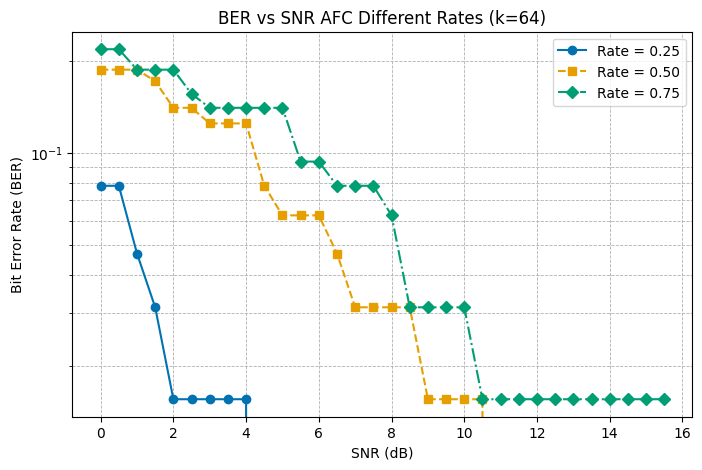

In [6]:
import matplotlib.pyplot as plt

colours = ["#0072B2", "#E69F00", "#009E73", "#D55E00"]
line_styles = ["-", "--", "-.", ":"]  # Different line styles
markers = ["o", "s", "D", "^"]  # Different marker shapes
plt.figure(figsize=(8, 5))
for i,(rate, ber) in enumerate(ber_results.items()):
    plt.semilogy(snr_values, ber, color=colours[i],marker=markers[i], linestyle=line_styles[i], label=f'Rate = {rate:.2f}')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title(f'BER vs SNR AFC Different Rates (k={k})')
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.legend()
plt.show()

In [2]:
import numpy as np
from scipy.sparse import csr_matrix

def ldpc_code(k, rate=0.5, snr_db=10, seed=42, max_bp_iterations=100):
    """
    Simulates an LDPC Code with specified rate.

    Parameters:
        k (int): Number of information bits.
        rate (float): Code rate (k/n), default 0.5.
        snr_db (float): Signal-to-noise ratio in dB (default: 10).
        seed (int): Random seed for reproducibility (default: 42).
        max_bp_iterations (int): Maximum belief propagation iterations (default: 100).

    Returns:
        dict: Results including information bits, decoded bits, error rate, etc.
    """
    np.random.seed(seed)  # Set random seed for reproducibility
    
    # Calculate n based on rate (k/n)
    n = int(k / rate)
    print(f"Using parameters: k={k}, n={n}, rate={rate:.4f}")

    # Step 1: Generate information bits
    information_bits = np.random.choice([-1, 1], k)
    
    # Step 2: Create parity check matrix and generator matrix
    H, var_to_check, check_to_var = create_parity_check_matrix(k, n)
    
    # Step 3: Encode the information bits
    encoded_bits = ldpc_encode(information_bits, H, n)
    
    # Step 4: Modulate using BPSK (1 -> +1, 0 -> -1)
    # (already in BPSK format from encoded_bits)
    
    # Step 5: Add AWGN noise
    snr_linear = 10 ** (snr_db / 10)
    std_dev = np.sqrt(1 / (2 * rate * snr_linear))  # Noise standard deviation
    noise = np.random.normal(0, std_dev, n)
    received = encoded_bits + noise
    
    print(f"SNR: {snr_db} dB, Noise variance: {std_dev**2}")
    
    # Step 6: Decode using belief propagation
    decoded_bits, iterations = ldpc_decode(received, H, var_to_check, check_to_var, std_dev**2, max_iterations=max_bp_iterations)
    
    print(f"Belief Propagation completed in {iterations} iterations")
    
    # Calculate bit error rate
    error_rate = np.sum(decoded_bits != information_bits) / k
    print(f"Bit Error Rate: {error_rate:.4f}\n")
    
    return {
        "information_bits": information_bits,
        "encoded_bits": encoded_bits,
        "decoded_bits": decoded_bits,
        "error_rate": error_rate,
        "iterations": iterations,
    }

def create_parity_check_matrix(k, n):
    """
    Creates a parity check matrix for LDPC codes using Progressive Edge Growth (PEG) algorithm.
    
    Parameters:
        k (int): Number of information bits.
        n (int): Codeword length.
        
    Returns:
        tuple: (H, var_to_check, check_to_var)
    """
    # Number of parity bits
    m = n - k
    
    # Target variable node degrees (column weights) - using a concentrated distribution
    var_degrees = np.zeros(n, dtype=int)
    
    # Create Gallager-like concentrated degree distribution
    if k / n >= 0.8:  # Very high rate codes
        var_degrees[:] = 3  # Higher column weight for high-rate codes
    elif k / n >= 0.5:  # Medium-high rate codes
        var_degrees[:k] = 3
        var_degrees[k:] = 4
    else:  # Lower rate codes
        var_degrees[:k] = 2
        var_degrees[k:] = 3
    
    # Check node degrees (row weights)
    # Calculate average row weight to meet the constraint: n * avg_col_weight = m * avg_row_weight
    avg_col_weight = np.mean(var_degrees)
    avg_row_weight = int(np.ceil((n * avg_col_weight) / m))
    
    # Initialize H as a sparse binary matrix
    H = np.zeros((m, n), dtype=int)
    
    # Initialize graph structures
    var_to_check = [[] for _ in range(n)]
    check_to_var = [[] for _ in range(m)]
    
    # Using Progressive Edge Growth (PEG) inspired approach
    for var in range(n):
        # Add connections for this variable node according to its degree
        for _ in range(var_degrees[var]):
            # Find check node with lowest degree so far
            check_degrees = [len(check_node) for check_node in check_to_var]
            
            # Filter check nodes that are already connected to this variable
            eligible_checks = [i for i in range(m) if i not in [c for c, _ in var_to_check[var]]]
            
            if not eligible_checks:
                # If all check nodes are already connected, break to avoid multiple edges
                break
                
            # Among eligible checks, find those with minimum degree
            min_degree = min(check_degrees[i] for i in eligible_checks)
            min_degree_checks = [i for i in eligible_checks if check_degrees[i] == min_degree]
            
            # Randomly select a check node from those with minimum degree
            selected_check = np.random.choice(min_degree_checks)
            
            # Add connection
            H[selected_check, var] = 1
            var_to_check[var].append((selected_check, 1.0))  # Weight is 1.0 for binary LDPC
            check_to_var[selected_check].append((var, 1.0))
    
    # Simplify the process to ensure matrix is full rank
    # Instead of complex swapping that might cause inconsistencies,
    # we'll just ensure the diagonal elements are set appropriately
    
    # First, clear any existing connections in the systematic part that might cause issues
    for i in range(min(m, n-k)):
        if k+i < n:  # Ensure we don't go out of bounds
            # Clear any existing connections to this systematic variable
            for row in np.where(H[:, k+i] > 0)[0]:
                H[row, k+i] = 0
                # Update connection lists
                check_to_var[row] = [(v, w) for v, w in check_to_var[row] if v != k+i]
            var_to_check[k+i] = []
            
            # Set the diagonal element
            H[i, k+i] = 1
            var_to_check[k+i].append((i, 1.0))
            check_to_var[i].append((k+i, 1.0))
    
    # Rebuild connection structures to ensure consistency
    # Clear all connections
    var_to_check = [[] for _ in range(n)]
    check_to_var = [[] for _ in range(m)]
    
    # Rebuild connections based on H matrix
    for check in range(m):
        for var in range(n):
            if H[check, var] == 1:
                var_to_check[var].append((check, 1.0))
                check_to_var[check].append((var, 1.0))
                
    # Verify connections are consistent (for debugging)
    for var in range(n):
        for check, _ in var_to_check[var]:
            if H[check, var] != 1:
                print(f"Warning: Inconsistency found in var_to_check at var={var}, check={check}")
                H[check, var] = 1  # Fix the inconsistency
    
    for check in range(m):
        for var, _ in check_to_var[check]:
            if H[check, var] != 1:
                print(f"Warning: Inconsistency found in check_to_var at check={check}, var={var}")
                H[check, var] = 1  # Fix the inconsistency
    
    return H, var_to_check, check_to_var

def ldpc_encode(info_bits, H, n):
    """
    Encode information bits using LDPC code.
    
    Parameters:
        info_bits (ndarray): Information bits.
        H (ndarray): Parity check matrix.
        n (int): Codeword length.
        
    Returns:
        ndarray: Encoded bits.
    """
    k = len(info_bits)
    m = n - k
    
    # Start with the systematic part
    codeword = np.zeros(n, dtype=np.float64)
    codeword[:k] = info_bits
    
    # For LDPC codes with a structured parity check matrix,
    # we can solve for parity bits more directly
    
    # Split H into information part and parity part
    H_info = H[:, :k]
    H_parity = H[:, k:]
    
    # Calculate syndrome
    syndrome = (H_info @ info_bits) % 2
    
    # Try iterative approach to solve for parity bits
    for i in range(m):
        # Calculate the value of this parity bit
        # We assume H_parity has been set up with a lower triangular structure
        # so each parity bit primarily depends on previous bits
        
        # First compute what the bit should be based on already determined bits
        bit_sum = 0
        
        # Include contribution from information bits
        for j in range(k):
            if H[i, j] == 1:
                bit_sum += info_bits[j]
        
        # Include contribution from previously determined parity bits
        for j in range(i):
            if H[i, k+j] == 1:
                bit_sum += codeword[k+j]
        
        # Set parity bit to maintain even parity (BPSK modulated, so use -1/+1)
        target_parity = syndrome[i] % 2  # 0 for even, 1 for odd
        if target_parity == 0:  # Even parity
            codeword[k+i] = -1 if (bit_sum % 2 == 0) else 1
        else:  # Odd parity
            codeword[k+i] = 1 if (bit_sum % 2 == 0) else -1
    
    return codeword

def ldpc_decode(received, H, var_to_check, check_to_var, sigma2, max_iterations=50, convergence_threshold=1e-4):
    """
    Decode LDPC code using belief propagation algorithm.
    
    Parameters:
        received (ndarray): Received symbols.
        H (ndarray): Parity check matrix.
        var_to_check (list): Variable node to check node connections with weights.
        check_to_var (list): Check node to variable node connections with weights.
        sigma2 (float): Noise variance.
        max_iterations (int): Maximum number of iterations.
        convergence_threshold (float): Threshold for convergence detection.
        
    Returns:
        tuple: (decoded_bits, iterations)
    """
    n = len(received)
    m = H.shape[0]  # Number of parity checks
    
    # Initialize LLRs from channel observations
    channel_llrs = 2 * received / sigma2
    
    # Initialize variable-to-check messages with channel LLRs
    var_to_check_msgs = {}
    for var in range(n):
        for check, _ in var_to_check[var]:
            var_to_check_msgs[(var, check)] = channel_llrs[var]
    
    # Initialize check-to-variable messages
    check_to_var_msgs = {}
    for check in range(m):
        for var, _ in check_to_var[check]:
            check_to_var_msgs[(check, var)] = 0.0
    
    # Variable for tracking variable node LLRs
    var_llrs = np.zeros(n)
    old_var_llrs = np.zeros(n)
    
    # For early stopping detection
    bit_decisions = np.zeros(n, dtype=int)
    prev_bit_decisions = np.zeros(n, dtype=int)
    stable_iterations = 0
    
    # Main decoding loop
    for iteration in range(max_iterations):
        # Store previous LLRs and decisions
        np.copyto(old_var_llrs, var_llrs)
        np.copyto(prev_bit_decisions, bit_decisions)
        
        # 1. Update check-to-variable messages
        for check in range(m):
            connected_vars = [var for var, _ in check_to_var[check]]
            
            for target_var in connected_vars:
                # Compute product of tanh(L/2) for all variables except target_var
                prod_tanh = 1.0
                for var in connected_vars:
                    if var != target_var:
                        # Get message from variable to this check
                        msg = var_to_check_msgs.get((var, check), 0.0)
                        
                        # Stabilized tanh computation
                        if abs(msg) > 15:  # Numerical stability threshold
                            tanh_val = 1.0 if msg > 0 else -1.0
                        else:
                            tanh_val = np.tanh(msg / 2)
                        
                        prod_tanh *= tanh_val
                
                # Compute new check-to-variable message
                if abs(prod_tanh) > 0.9999:  # Numerical stability for atanh
                    new_msg = 15.0 if prod_tanh > 0 else -15.0
                else:
                    new_msg = 2 * np.arctanh(prod_tanh)
                
                # Update message
                check_to_var_msgs[(check, target_var)] = new_msg
        
        # 2. Update variable-to-check messages
        for var in range(n):
            # Channel evidence
            channel_llr = channel_llrs[var]
            
            # Connected check nodes
            connected_checks = [check for check, _ in var_to_check[var]]
            
            for target_check in connected_checks:
                # Sum all incoming messages except from target_check
                msg_sum = channel_llr
                for check in connected_checks:
                    if check != target_check:
                        msg_sum += check_to_var_msgs.get((check, var), 0.0)
                
                # Update message
                var_to_check_msgs[(var, target_check)] = msg_sum
        
        # 3. Compute total LLR for each variable node
        for var in range(n):
            # Channel evidence
            var_llrs[var] = channel_llrs[var]
            
            # Add all messages from connected check nodes
            for check, _ in var_to_check[var]:
                var_llrs[var] += check_to_var_msgs.get((check, var), 0.0)
        
        # Make hard decisions
        bit_decisions = np.where(var_llrs > 0, 1, -1)
        
        # Check if parity checks are satisfied
        syndrome = np.zeros(m, dtype=int)
        for check in range(m):
            parity = 0
            for var, _ in check_to_var[check]:
                parity = (parity + (1 if bit_decisions[var] > 0 else 0)) % 2
            syndrome[check] = parity
        
        # If all parity checks are satisfied, we're done
        if np.sum(syndrome) == 0:
            break
        
        # Check for stability in decisions
        if np.array_equal(bit_decisions, prev_bit_decisions):
            stable_iterations += 1
            if stable_iterations >= 3:  # Early stopping if decisions stable for 3 iterations
                break
        else:
            stable_iterations = 0
        
        # Check for convergence in LLRs
        if np.max(np.abs(var_llrs - old_var_llrs)) < convergence_threshold:
            break
    
    return bit_decisions, iteration+1

def compare_performance(k_values, rate_values, snr_db_values, num_trials=10):
    """
    Compare performance of LDPC and Analog Fountain codes.
    
    Parameters:
        k_values (list): List of information bit lengths to test.
        rate_values (list): List of code rates to test.
        snr_db_values (list): List of SNR values in dB to test.
        num_trials (int): Number of trials to average results over.
        
    Returns:
        dict: Performance comparison results.
    """
    results = {
        'ldpc': {},
        'analog_fountain': {}
    }
    
    # Try to import the analog_fountain_code function
    try:
        # First try importing from a module named 'paste'
        import paste
        analog_fountain_code_fn = paste.analog_fountain_code
        afc_available = True
        print("Imported analog_fountain_code from paste module")
    except (ImportError, AttributeError):
        try:
            # Then try importing it from the main namespace
            from __main__ import analog_fountain_code as analog_fountain_code_fn
            afc_available = True
            print("Imported analog_fountain_code from main namespace")
        except (ImportError, NameError):
            print("Warning: analog_fountain_code function not available, will only run LDPC simulations")
            afc_available = False
    
    for k in k_values:
        results['ldpc'][k] = {}
        results['analog_fountain'][k] = {}
        
        for rate in rate_values:
            results['ldpc'][k][rate] = {}
            results['analog_fountain'][k][rate] = {}
            
            for snr_db in snr_db_values:
                # Run multiple trials and average results
                ldpc_ber = 0
                afc_ber = 0
                ldpc_iters = 0
                afc_iters = 0
                
                for trial in range(num_trials):
                    # Set different seed for each trial
                    seed = 42 + trial
                    
                    # Run LDPC simulation
                    print(f"Running LDPC simulation: k={k}, rate={rate}, SNR={snr_db} dB, trial {trial+1}/{num_trials}")
                    ldpc_result = ldpc_code(k, rate, snr_db, seed)
                    ldpc_ber += ldpc_result['error_rate']
                    ldpc_iters += ldpc_result['iterations']
                    
                    # Run Analog Fountain Code simulation if available
                    if afc_available:
                        print(f"Running Analog Fountain Code simulation: k={k}, rate={rate}, SNR={snr_db} dB, trial {trial+1}/{num_trials}")
                        try:
                            afc_result = analog_fountain_code_fn(k, rate, snr_db, seed)
                            afc_ber += afc_result['error_rate']
                            afc_iters += afc_result['iterations']
                        except Exception as e:
                            print(f"Error running Analog Fountain Code: {e}")
                            afc_available = False
                            afc_ber = float('nan')
                            afc_iters = float('nan')
                            break
                
                # Average results
                ldpc_ber /= num_trials
                ldpc_iters /= num_trials
                
                if afc_available:
                    afc_ber /= num_trials
                    afc_iters /= num_trials
                
                # Store results
                results['ldpc'][k][rate][snr_db] = {
                    'ber': ldpc_ber,
                    'avg_iterations': ldpc_iters
                }
                
                results['analog_fountain'][k][rate][snr_db] = {
                    'ber': afc_ber,
                    'avg_iterations': afc_iters
                }
                
                print(f"k={k}, rate={rate}, SNR={snr_db} dB:")
                print(f"  LDPC: BER={ldpc_ber:.6f}, Avg. Iterations={ldpc_iters:.2f}")
                if afc_available:
                    print(f"  AFC:  BER={afc_ber:.6f}, Avg. Iterations={afc_iters:.2f}")
                print()
    
    return results

# Example usage
if __name__ == "__main__":
    # Test LDPC code
    print("Testing LDPC code:")
    result = ldpc_code(k=100, rate=0.5, snr_db=5)
    
    # Compare with Analog Fountain Code
    try:
        from __main__ import analog_fountain_code
        print("\nComparing LDPC and Analog Fountain codes:")
        results = compare_performance(
            k_values=[100, 200],
            rate_values=[0.5, 0.8],
            snr_db_values=[3, 5, 7],
            num_trials=3
        )
    except (ImportError, NameError):
        print("Analog Fountain Code function not available, skipping comparison")

Testing LDPC code:
Using parameters: k=100, n=200, rate=0.5000
SNR: 5 dB, Noise variance: 0.31622776601683794
Belief Propagation completed in 100 iterations


C:\Users\nazmi\AppData\Local\Temp\ipykernel_14392\2466763456.py:50: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  error_rate = np.sum(decoded_bits != information_bits) / k


Bit Error Rate: 0.0100


Comparing LDPC and Analog Fountain codes:
Imported analog_fountain_code from main namespace
Running LDPC simulation: k=100, rate=0.5, SNR=3 dB, trial 1/3
Using parameters: k=100, n=200, rate=0.5000
SNR: 3 dB, Noise variance: 0.5011872336272722
Belief Propagation completed in 100 iterations
Bit Error Rate: 0.0100

Running Analog Fountain Code simulation: k=100, rate=0.5, SNR=3 dB, trial 1/3
Using parameters: k=100, n=200, rate=0.500000
SNR: 3 dB, Noise variance: 0.208
Belief Propagation completed in 3 iterations
Bit Error Rate: 0.0500

Running LDPC simulation: k=100, rate=0.5, SNR=3 dB, trial 2/3
Using parameters: k=100, n=200, rate=0.5000
SNR: 3 dB, Noise variance: 0.5011872336272722
Belief Propagation completed in 100 iterations
Bit Error Rate: 0.0100

Running Analog Fountain Code simulation: k=100, rate=0.5, SNR=3 dB, trial 2/3
Using parameters: k=100, n=200, rate=0.500000
SNR: 3 dB, Noise variance: 0.2272
Belief Propagation completed in 3 iterations
Bit Erro

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os

def analog_fountain_code(k, rate=0.5, snr_db=10, seed=42, max_bp_iterations=100):
    """
    Simulates an Analog Fountain Code with specified rate.

    Parameters:
        k (int): Number of information bits.
        rate (float): Code rate (k/n), default 0.5.
        snr_db (float): Signal-to-noise ratio in dB (default: 10).
        seed (int): Random seed for reproducibility (default: 42).
        max_bp_iterations (int): Maximum belief propagation iterations (default: 10).

    Returns:
        dict: Decoded information with generator matrix, encoded symbols, decoding metrics, and decoded bits.
    """
    np.random.seed(seed)  # Set random seed for reproducibility
    
    # Calculate n based on rate (k/n)
    n = int(k / rate)
    print(f"Using parameters: k={k}, n={n}, rate={rate:4f}")

    # Step 1: Generate information bits
    information_bits = np.random.choice([-1, 1], k)
    # print(f"Information bits (BPSK modulated): {information_bits}")

    # Step 2: Create improved generator matrix and connection graph
    # Use improved degree distribution for better performance at higher rates
    G, var_to_check, check_to_var = create_generator_matrix(k, n, rate)

    # Step 3: Compute encoded symbols
    encoded_symbols = G @ information_bits
    
    # Step 4: Calculate noise variance and generate noise
    psignal = (1 / n) * np.sum(np.square(encoded_symbols))
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = round(psignal / snr_linear, 4)
    std_dev = np.sqrt(sigma2)
    noise_values = np.round(np.random.normal(0, std_dev, n), 4)
    
    # Step 5: Compute received symbols
    u = np.round(encoded_symbols + noise_values, 4)
    print(f"SNR: {snr_db} dB, Noise variance: {sigma2}")
    # print(f"First few received symbols: {u[:min(5, n)]}")
    
    # Belief Propagation with LLR
    decoded_bits, iterations = csbp_decoder(
        u, G, var_to_check, check_to_var, sigma2, k, n, max_iterations=max_bp_iterations
    )
    
    print(f"Belief Propagation completed in {iterations} iterations")
    # print(f"Decoded bits: {decoded_bits[:10]}...")
    
    # Calculate bit error rate
    error_rate = np.sum(decoded_bits != information_bits) / k
    print(f"Bit Error Rate: {error_rate:.4f}\n")
    
    return {
        "information_bits": information_bits,
        "decoded_bits": decoded_bits,
        "error_rate": error_rate,
        "generator_matrix": G,
        "iterations": iterations,
    }

def create_generator_matrix(k, n, rate):
    """
    Creates an improved generator matrix for analog fountain codes.
    
    Parameters:
        k (int): Number of information bits.
        n (int): Number of encoded symbols.
        rate (float): Code rate (k/n).
        
    Returns:
        tuple: (generator_matrix, var_to_check, check_to_var)
    """
    safe_rate = min(0.99, rate)
    G = np.zeros((n, k))
    # Create bipartite graph representations for belief propagation
    var_to_check = [[] for _ in range(k)]  # Variable nodes to check nodes connections
    check_to_var = [[] for _ in range(n)]  # Check nodes to variable nodes connections
    
    # 1. Improved degree distribution based on code rate
    if safe_rate >= 0.8:  # Very high rate - needs more connections
        # For high rates, ensure every variable node is connected to multiple check nodes
        min_degree = max(3, int(1.5 / (1 - safe_rate)))  # More aggressive minimum degree
        max_degree = min(k, int(min(15, k/5)))  # Limit maximum degree
        
        # Use more concentrated degree distribution for high rates
        degrees = np.arange(min_degree, max_degree + 1)
        if len(degrees) > 0:  # Ensure degrees array is not empty
            # Modified Robust Soliton for higher rates
            degree_probs = 1.0 / (degrees * np.log(degrees + 1))
            degree_probs /= degree_probs.sum()
        else:
            # Fallback for extreme cases
            degrees = np.array([min(3, k)])
            degree_probs = np.array([1.0])
        
    elif safe_rate >= 0.5:  # Medium-high rate
        # For medium-high rates, use robust degree distribution
        min_degree = max(2, int(1 / (1 - safe_rate)))
        max_degree = min(k, int(min(10, k/4)))
        
        degrees = np.arange(min_degree, max_degree + 1)
        if len(degrees) > 0:
            # Robust Soliton-like distribution 
            degree_probs = 1.0 / (degrees * (degrees + 1))
            degree_probs /= degree_probs.sum()
        else:
            degrees = np.array([min(2, k)])
            degree_probs = np.array([1.0])
        
    else:  # Lower rates - can use more standard distributions
        # For lower rates, standard LT-code inspired distribution
        min_degree = 1
        max_degree = min(k, 10)
        
        degrees = np.arange(min_degree, max_degree + 1)
        # Standard Soliton distribution
        degree_probs = 1.0 / degrees
        degree_probs /= degree_probs.sum()
    
    # Normalize probabilities
    degree_probs /= degree_probs.sum()
    
# 2. Handle extreme case: if n ≈ k (rate ≈ 1), make it fully systematic with small perturbations
    if n <= k or safe_rate > 0.95:
        print(f"Using fully systematic design (rate = {rate:.4f})")
        # Fully systematic with small perturbations
        for i in range(min(n, k)):
            main_col = i % k
            G[i, main_col] = 0.95  # Main diagonal weight
            
            # Add a few random connections for stability
            remaining_cols = [j for j in range(k) if j != main_col]
            if remaining_cols:  # Ensure we have remaining columns
                num_extra = min(max(1, int(k * 0.01)), len(remaining_cols))
                extra_cols = np.random.choice(remaining_cols, size=num_extra, replace=False)
                extra_weights = np.random.rand(len(extra_cols)) * 0.05
                extra_weights /= extra_weights.sum()  # Normalize to 0.05
                
                for j, col in enumerate(extra_cols):
                    G[i, col] = extra_weights[j]
                
                # Update graph connections
                var_to_check[main_col].append((i, 0.95))
                check_to_var[i].append((main_col, 0.95))
                
                for j, col in enumerate(extra_cols):
                    var_to_check[col].append((i, extra_weights[j]))
                    check_to_var[i].append((col, extra_weights[j]))
            else:
                # If k=1 edge case, just use the full weight on the single column
                G[i, main_col] = 1.0
                var_to_check[main_col].append((i, 1.0))
                check_to_var[i].append((main_col, 1.0))
                
        # For cases where n > k, add some redundant rows
        if n > k:
            for i in range(k, n):
                # Copy a random systematic row with small variations
                source_row = np.random.randint(0, k)
                main_col = source_row
                
                # Use slightly different weight distribution
                G[i, main_col] = 0.9  # Slightly less weight on main column
                
                # Add random connections to other columns
                remaining_cols = [j for j in range(k) if j != main_col]
                if remaining_cols:
                    num_extra = min(max(2, int(k * 0.05)), len(remaining_cols))
                    extra_cols = np.random.choice(remaining_cols, size=num_extra, replace=False)
                    extra_weights = np.random.rand(len(extra_cols)) * 0.1
                    extra_weights /= extra_weights.sum()  # Normalize to 0.1
                    
                    for j, col in enumerate(extra_cols):
                        G[i, col] = extra_weights[j]
                    
                    # Update graph connections
                    var_to_check[main_col].append((i, 0.9))
                    check_to_var[i].append((main_col, 0.9))
                    
                    for j, col in enumerate(extra_cols):
                        var_to_check[col].append((i, extra_weights[j]))
                        check_to_var[i].append((col, extra_weights[j]))
                else:
                    # Edge case for k=1
                    G[i, main_col] = 1.0
                    var_to_check[main_col].append((i, 1.0))
                    check_to_var[i].append((main_col, 1.0))
                    
        return G, var_to_check, check_to_var
    
    # 3. Create systematic part for improved performance at high rates
    systematic_rows = 0
    if safe_rate > 0.7:
        # Systematic part: First k output symbols are directly connected to input symbols
        systematic_rows = min(k, int(n * 0.8))  # Use up to 80% of rows for systematic part
        for i in range(systematic_rows):
            # Use diagonal structure with small random perturbations for numerical stability
            col_idx = i % k  # Handle case where n might be smaller than k
            G[i, col_idx] = 0.95  # Main weight on the systematic connection
            
            # Add a few random connections with small weights
            num_extra = max(1, int(k * 0.01))  # Add small number of extra connections
            extra_cols = np.random.choice([j for j in range(k) if j != col_idx], 
                                        size=min(num_extra, k-1), 
                                        replace=False)
            if len(extra_cols) > 0:
                extra_weights = np.random.rand(len(extra_cols)) * 0.05  # Small weights
                extra_weights /= extra_weights.sum()  # Normalize to sum to 0.05
                
                for j, extra_col in enumerate(extra_cols):
                    G[i, extra_col] = extra_weights[j]
                
                # Update graph connections
                var_to_check[col_idx].append((i, 0.95))  # Main connection
                check_to_var[i].append((col_idx, 0.95))  # Main connection
                
                for j, extra_col in enumerate(extra_cols):
                    var_to_check[extra_col].append((i, extra_weights[j]))
                    check_to_var[i].append((extra_col, extra_weights[j]))
            else:
                # Edge case if k=1
                G[i, col_idx] = 1.0  # Full weight on the only available connection
                var_to_check[col_idx].append((i, 1.0))
                check_to_var[i].append((col_idx, 1.0))
    
    # 4. Create non-systematic part with improved weight distribution
    # Skip this part if we've already used all available rows
    if systematic_rows < n:
        for i in range(systematic_rows, n):
            # Choose degree based on the rate-specific distribution
            # Protect against empty degree array or degree > k
            if len(degrees) > 0:
                degree = np.random.choice(degrees, p=degree_probs)
                degree = min(degree, k)  # Ensure degree doesn't exceed k
            else:
                degree = min(3, k)  # Fallback degree
            
            connected_columns = np.random.choice(k, degree, replace=False)
            
            # Improved weight generation based on degree
            if degree == 1:
                # Single connection gets full weight
                weights = np.array([1.0])
            else:
                # Generate weights with improved distribution for multiple connections
                if safe_rate > 0.7:
                    # For high rates, make weights more balanced
                    alpha = 2.0  # Higher alpha = more uniform weights
                    weights = np.random.beta(alpha, alpha, size=degree)
                else:
                    # For lower rates, allow more varied weights
                    weights = np.random.rand(degree)
                    
                # Ensure weights sum to 1
                weights /= weights.sum()
            
            # Round weights for numerical stability
            weights = np.round(weights, 4)
            
            # Adjust if rounding caused sum != 1
            if weights.sum() != 1.0:
                weights[-1] += 1.0 - weights.sum()
                weights[-1] = round(weights[-1], 4)
            
            # Populate generator matrix and graph connections
            for j, (col, weight) in enumerate(zip(connected_columns, weights)):
                G[i, col] = weight
                var_to_check[col].append((i, weight))
                check_to_var[i].append((col, weight))
    
    # 5. Balance variable node degrees - ensure each variable is connected to enough check nodes
    min_var_connections = max(2, int(2 / (1 - min(0.95, safe_rate))))
    
    for var_idx in range(k):
        if len(var_to_check[var_idx]) < min_var_connections:
            # Add more connections to this variable node
            additional_needed = min_var_connections - len(var_to_check[var_idx])
            
            # Find check nodes that this variable is not yet connected to
            connected_checks = {conn[0] for conn in var_to_check[var_idx]}
            available_checks = [i for i in range(n) if i not in connected_checks]
            
            if len(available_checks) >= additional_needed:
                new_checks = np.random.choice(available_checks, additional_needed, replace=False)
                
                for check_idx in new_checks:
                    # Add connection with small weight
                    weight = 0.1
                    
                    # Adjust other weights in this check node to maintain sum = 1
                    if check_to_var[check_idx]:  # If there are existing connections
                        total_current_weight = sum(w for _, w in check_to_var[check_idx])
                        if total_current_weight > 0:  # Avoid division by zero
                            scale_factor = (1.0 - weight) / total_current_weight
                            
                            # Update existing connections
                            for j in range(len(check_to_var[check_idx])):
                                old_var, old_weight = check_to_var[check_idx][j]
                                new_weight = round(old_weight * scale_factor, 4)
                                check_to_var[check_idx][j] = (old_var, new_weight)
                                
                                # Update the corresponding var_to_check entry
                                for v_idx, (c_idx, w) in enumerate(var_to_check[old_var]):
                                    if c_idx == check_idx:
                                        var_to_check[old_var][v_idx] = (c_idx, new_weight)
                                        G[c_idx, old_var] = new_weight
                                        break
                        else:
                            # If current weight is 0, just add the new connection with weight 1
                            weight = 1.0
                    else:
                        # If no existing connections, use full weight
                        weight = 1.0
                    
                    # Add new connection
                    var_to_check[var_idx].append((check_idx, weight))
                    check_to_var[check_idx].append((var_idx, weight))
                    G[check_idx, var_idx] = weight
            elif available_checks:  # If we have some but not enough available checks
                # Use whatever is available
                for check_idx in available_checks:
                    # Similar logic to above, but with available checks
                    weight = 0.1
                    
                    # Adjust weights as above
                    if check_to_var[check_idx]:
                        total_current_weight = sum(w for _, w in check_to_var[check_idx])
                        if total_current_weight > 0:
                            scale_factor = (1.0 - weight) / total_current_weight
                            
                            # Update existing connections
                            for j in range(len(check_to_var[check_idx])):
                                old_var, old_weight = check_to_var[check_idx][j]
                                new_weight = round(old_weight * scale_factor, 4)
                                check_to_var[check_idx][j] = (old_var, new_weight)
                                
                                # Update the corresponding var_to_check entry
                                for v_idx, (c_idx, w) in enumerate(var_to_check[old_var]):
                                    if c_idx == check_idx:
                                        var_to_check[old_var][v_idx] = (c_idx, new_weight)
                                        G[c_idx, old_var] = new_weight
                                        break
                        else:
                            weight = 1.0
                    else:
                        weight = 1.0
                    
                    # Add new connection
                    var_to_check[var_idx].append((check_idx, weight))
                    check_to_var[check_idx].append((var_idx, weight))
                    G[check_idx, var_idx] = weight
    
    # 6. Normalize generator matrix rows again to ensure each row sums to 1
    for i in range(n):
        row_sum = G[i].sum()
        if row_sum > 0:  # Avoid division by zero
            G[i] = np.round(G[i] / row_sum, 4)
            
            # Update connection weights
            for j in range(len(check_to_var[i])):
                var_idx, _ = check_to_var[i][j]
                new_weight = G[i, var_idx]
                check_to_var[i][j] = (var_idx, new_weight)
                
                # Update corresponding var_to_check
                for v_idx, (c_idx, _) in enumerate(var_to_check[var_idx]):
                    if c_idx == i:
                        var_to_check[var_idx][v_idx] = (c_idx, new_weight)
                        break
    
    return G, var_to_check, check_to_var

def csbp_decoder(received, G, var_to_check, check_to_var, sigma2, k, n, max_iterations=50, convergence_threshold=1e-4, damping_factor=0.8):
    """
    Fully vectorized Compressive Sensing Belief Propagation decoder for Analog Fountain Codes.
    
    Parameters:
        received (ndarray): Received symbols
        G (ndarray): Generator matrix
        var_to_check (list): Variable node to check node connections with weights
        check_to_var (list): Check node to variable node connections with weights
        sigma2 (float): Noise variance
        k (int): Number of information bits
        n (int): Total number of received symbols
        max_iterations (int): Maximum number of iterations
        convergence_threshold (float): Threshold for convergence detection
        damping_factor (float): Damping factor to improve convergence (0.8 default)
        
    Returns:
        tuple: (decoded_bits, iterations)
    """
    # Pre-compute all connection indices and weights for efficient vectorization
    max_var_degree = max(len(conn) for conn in var_to_check)
    max_check_degree = max(len(conn) for conn in check_to_var)
    
    # Create structured arrays for connections and weights
    var_connections = -np.ones((k, max_var_degree), dtype=int)
    var_weights = np.zeros((k, max_var_degree))
    check_connections = -np.ones((n, max_check_degree), dtype=int)
    check_weights = np.zeros((n, max_check_degree))
    
    # Fill connection matrices
    for i in range(k):
        for j, (check_idx, weight) in enumerate(var_to_check[i]):
            var_connections[i, j] = check_idx
            var_weights[i, j] = weight
    
    for i in range(n):
        for j, (var_idx, weight) in enumerate(check_to_var[i]):
            check_connections[i, j] = var_idx
            check_weights[i, j] = weight
    
    # Create masks for valid connections
    var_masks = var_connections >= 0
    check_masks = check_connections >= 0
    
    # Initialize messages
    var_to_check_msgs = np.zeros((k, max_var_degree))
    check_to_var_msgs = np.zeros((n, max_check_degree))
    prev_check_to_var_msgs = np.zeros((n, max_check_degree))
    
    # Initialize check messages with channel evidence
    for i in range(n):
        check_to_var_msgs[i, check_masks[i]] = 2 * received[i] * check_weights[i, check_masks[i]] / sigma2
    
    # Variable for tracking variable node LLRs
    var_llrs = np.zeros(k)
    old_var_llrs = np.zeros(k)

    # For early stopping detection
    bit_decisions = np.zeros(k)
    prev_bit_decisions = np.zeros(k)
    stable_iterations = 0
    
    # Main decoding loop
    for iteration in range(max_iterations):
        # Store previous LLRs and decisions
        np.copyto(old_var_llrs, var_llrs)
        np.copyto(prev_bit_decisions, bit_decisions)
        np.copyto(prev_check_to_var_msgs, check_to_var_msgs)
        
        # 1. Update variable-to-check messages
        # For each variable node, compute total incoming messages
        for var_idx in range(k):
            # Valid check nodes connected to this variable
            valid_checks = var_connections[var_idx, var_masks[var_idx]]
            
            # For each connected check node, find the message index
            for j, check_idx in enumerate(valid_checks):
                # Find where this variable appears in the check node's connections
                check_conn = check_connections[check_idx]
                pos = np.where(check_conn == var_idx)[0][0]
                
                # Collect all incoming messages to this variable except from current check
                all_msgs = []
                for other_check_idx in valid_checks:
                    if other_check_idx == check_idx:
                        continue
                    # Find position of variable in other check's connections
                    other_pos = np.where(check_connections[other_check_idx] == var_idx)[0][0]
                    all_msgs.append(check_to_var_msgs[other_check_idx, other_pos])
                
                # Sum all other messages
                var_to_check_msgs[var_idx, j] = sum(all_msgs) if all_msgs else 0
        
        # 2. Update check-to-variable messages
        for check_idx in range(n):
            rec_symbol = received[check_idx]
            valid_vars = check_connections[check_idx, check_masks[check_idx]]
            valid_weights = check_weights[check_idx, check_masks[check_idx]]
            
            for j, var_idx in enumerate(valid_vars):
                # Find where this check appears in the variable node's connections
                var_conn = var_connections[var_idx]
                pos = np.where(var_conn == check_idx)[0][0]
                
                # Calculate expected symbol excluding current variable
                other_vars = valid_vars[valid_vars != var_idx]
                other_weights = valid_weights[valid_vars != var_idx]
                soft_bits = np.zeros_like(other_vars, dtype=float)
                
                for idx, other_var in enumerate(other_vars):
                    # Find position of check in other variable's connections
                    other_pos = np.where(var_connections[other_var] == check_idx)[0][0]
                    msg = var_to_check_msgs[other_var, other_pos]
                    
                    # Stabilized tanh computation
                    if abs(msg) > 15:
                        soft_bits[idx] = 1.0 if msg > 0 else -1.0
                    else:
                        soft_bits[idx] = np.tanh(msg / 2)
                
                # Compute expected symbol and residual
                expected_symbol = np.sum(other_weights * soft_bits)
                residual = rec_symbol - expected_symbol
                
                # Calculate new message
                weight = valid_weights[j]
                new_msg = 2 * residual * weight / sigma2
                
                # Apply damping for better convergence
                check_to_var_msgs[check_idx, j] = damping_factor * new_msg + (1 - damping_factor) * prev_check_to_var_msgs[check_idx, j]
        
        # 3. Compute total LLR for each variable node
        var_llrs.fill(0)
        for var_idx in range(k):
            valid_checks = var_connections[var_idx, var_masks[var_idx]]
            for check_idx in valid_checks:
                # Find position of variable in check's connections
                pos = np.where(check_connections[check_idx] == var_idx)[0][0]
                var_llrs[var_idx] += check_to_var_msgs[check_idx, pos]
        
        # Make hard decisions
        decoded_bits = np.where(var_llrs > 0, 1, -1)

        # Check for stability in decisions
        if np.array_equal(bit_decisions, prev_bit_decisions):
            stable_iterations += 1
            if stable_iterations >= 3:  # Early stopping if decisions stable for 3 iterations
                break
        else:
            stable_iterations = 0
        
        # Check for convergence in LLRs
        if np.max(np.abs(var_llrs - old_var_llrs)) < convergence_threshold:
            break
    
    # Final hard decisions
    decoded_bits = np.where(var_llrs > 0, 1, -1)
    
    # Print diagnostics
    # print(f"\nDecoding completed after {iteration+1} iterations")
    # print("Final Variable Node LLRs:")
    # for i in range(min(10, k)):
    #     print(f"Var {i}: LLR = {var_llrs[i]:.4f}, Decoded = {decoded_bits[i]}")
    
    return decoded_bits, iteration+1

def simulate_afc_performance(k=100, rate=0.5, snr_range=np.arange(0, 16, 1), 
                           num_tests=1000, max_bp_iterations=100, seed_start=42):
    """
    Simulates Analog Fountain Code performance for multiple tests across different SNR values.
    
    Parameters:
        k (int): Number of information bits.
        rate (float): Code rate (k/n).
        snr_range (ndarray): Range of SNR values to test.
        num_tests (int): Number of tests to run per SNR point.
        max_bp_iterations (int): Maximum belief propagation iterations.
        seed_start (int): Starting seed for random number generation.
        
    Returns:
        dict: Results containing BER and BLER for each SNR point.
    """
    n = int(k / rate)
    results = {
        'snr': snr_range,
        'ber': [],
        'bler': [],
        'bit_errors': [],
        'block_errors': [],
        'avg_iterations': [],
        'time_taken': []
    }
    
    print(f"\nRunning AFC simulation with {num_tests} tests per SNR point:")
    print(f"Parameters: k={k}, n={n}, rate={rate:.4f}, max_bp_iterations={max_bp_iterations}")
    print("\nSNR (dB) | BER       | BLER      | Block Errors | Avg Iter | Time (s)")
    print("-" * 75)
    
    for snr_db in snr_range:
        start_time = time.time()
        total_bit_errors = 0
        block_errors = 0
        total_iterations = 0
        
        # Run multiple tests for this SNR point
        for test_idx in range(num_tests):
            # Set different seed for each test
            test_seed = seed_start + test_idx 
            
            # Temporarily redirect stdout to suppress per-test messages
            original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')
            
            # Run the AFC simulation
            result = analog_fountain_code(k, rate, snr_db, test_seed, max_bp_iterations)
            
            # Restore stdout
            sys.stdout.close()
            sys.stdout = original_stdout
            
            # Count errors
            bit_errors_in_block = np.sum(result["decoded_bits"] != result["information_bits"])
            total_bit_errors += bit_errors_in_block
            
            # Check if block had any errors
            if bit_errors_in_block > 0:
                block_errors += 1
            
            # Track iterations
            total_iterations += result["iterations"]
            
            # Show progress every 100 tests or at the end
            if (test_idx + 1) % 100 == 0 or test_idx == num_tests - 1:
                current_ber = total_bit_errors / ((test_idx + 1) * k)
                current_bler = block_errors / (test_idx + 1)
                current_avg_iter = total_iterations / (test_idx + 1)
                current_time = time.time() - start_time
                
                # Print progress update (overwrite the same line)
                sys.stdout.write('\r')
                sys.stdout.write(f"{snr_db:7.1f} | {current_ber:.3e} | {current_bler:.3e} | "
                                f"{block_errors:12d} | {current_avg_iter:8.2f} | {current_time:8.2f} | "
                                f"Progress: {test_idx+1}/{num_tests}")
                sys.stdout.flush()
        
        # Calculate final metrics for this SNR point
        ber = total_bit_errors / (num_tests * k)
        bler = block_errors / num_tests
        avg_iterations = total_iterations / num_tests
        time_taken = time.time() - start_time
        
        # Store results
        results['ber'].append(ber)
        results['bler'].append(bler)
        results['bit_errors'].append(total_bit_errors)
        results['block_errors'].append(block_errors)
        results['avg_iterations'].append(avg_iterations)
        results['time_taken'].append(time_taken)
        
        # Print final result for this SNR point (with newline)
        print(f"\r{snr_db:7.1f} | {ber:.3e} | {bler:.3e} | "
              f"{block_errors:12d} | {avg_iterations:8.2f} | {time_taken:8.2f} | Complete{' '*20}")
    
    return results

def plot_performance(results, k, rate, label="AFC-CSBP"):
    """
    Creates two separate plots: BER vs SNR and BLER vs SNR.
    
    Parameters:
        results (dict): Simulation results.
        k (int): Number of information bits.
        rate (float): Code rate.
        label (str): Label for the curve.
    """
    n = int(k / rate)
    
    # 1. BER vs SNR Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(results['snr'], results['ber'], 'o-', color='#1f77b4', linewidth=2, 
                markersize=8, label=f"{label} R={rate}")
    
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('BER', fontsize=12)
    plt.title(f'Performance of Analog Fountain Code (K={k}, N={n})', fontsize=14)
    plt.xlim(0, 15)
    
    # Set y-axis limits based on data
    min_error = max(1e-3, min(filter(lambda x: x > 0, results['ber'])))
    plt.ylim(min_error / 2, 1)
    
    plt.legend(fontsize=10)
    plt.savefig(f'afc_ber_performance_k{k}_n{n}_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. BLER vs SNR Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(results['snr'], results['bler'], 's-', color='red', linewidth=2, 
                markersize=8, label=f"{label} R={rate}")
    
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('BLER', fontsize=12)
    plt.title(f'Performance of Analog Fountain Code (K={k}, N={n})', fontsize=14)
    plt.xlim(0, 15)
    
    # Set y-axis limits based on data
    min_error = max(1e-3, min(filter(lambda x: x > 0, results['bler'])))
    plt.ylim(min_error / 2, 1)
    
    plt.legend(fontsize=10)
    plt.savefig(f'afc_bler_performance_k{k}_n{n}_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_results_to_csv(results, k, rate, label="AFC-CSBP"):
    """
    Save simulation results to a CSV file.
    
    Parameters:
        results (dict): Simulation results.
        k (int): Number of information bits.
        rate (float): Code rate.
        label (str): Label for the file name.
    """
    n = int(k / rate)
    
    data = np.column_stack((
        results['snr'], 
        results['ber'], 
        results['bler'],
        results['bit_errors'],
        results['block_errors'],
        results['avg_iterations'],
        results['time_taken']
    ))
    
    header = 'SNR_dB,BER,BLER,bit_errors,block_errors,avg_iterations,time_taken'
    np.savetxt(f'afc_performance_k{k}_n{n}_{label}.csv', data, delimiter=',', header=header, comments='')
    print(f"\nResults saved to afc_performance_k{k}_n{n}_{label}.csv")

# Main execution function
def run_afc_simulation(k=64, rate=0.5, max_bp_iterations=200, num_tests=1000, 
                      snr_start=0, snr_end=15, snr_step=1, seed_start=42,
                      label="AFC-CSBP-100"):
    """
    Run the complete BER/BLER vs SNR simulation using simulate_afc_performance.
    
    Parameters:
        k (int): Number of information bits.
        rate (float): Code rate.
        max_bp_iterations (int): Maximum belief propagation iterations.
        num_tests (int): Number of tests to run per SNR point.
        snr_start (float): Starting SNR value in dB.
        snr_end (float): Ending SNR value in dB.
        snr_step (float): Step size for SNR values.
        seed_start (int): Starting seed for random number generation.
        label (str): Label for plotting and saving results.
    """
    # Calculate n (codeword length)
    n = int(k / rate)
    
    # Define SNR range
    snr_range = np.arange(snr_start, snr_end + snr_step, snr_step)
    
    print(f"\nRunning Analog Fountain Code simulation with:")
    print(f"- Information bits (K): {k}")
    print(f"- Codeword length (N): {n}")
    print(f"- Code rate (R): {rate}")
    print(f"- Tests per SNR point: {num_tests}")
    print(f"- Max BP iterations: {max_bp_iterations}")
    print(f"- SNR range: {snr_start} to {snr_end} dB")
    
    # Run simulation
    results = simulate_afc_performance(
        k=k,
        rate=rate,
        snr_range=snr_range,
        num_tests=num_tests,
        max_bp_iterations=max_bp_iterations,
        seed_start=seed_start
    )
    
    # Plot the results (BER and BLER)
    plot_performance(results, k, rate, label)
    
    # Save results to CSV
    save_results_to_csv(results, k, rate, label)
    
    return results

if __name__ == "__main__":
    k = 64  # Information bits
    rate = 0.5  # Code rate
    
    # Run simulation with recommended parameters
    results = run_afc_simulation(
        k=k,
        rate=rate,
        max_bp_iterations=100,  
        num_tests=1000,       
        snr_start=0,
        snr_end=15,
        snr_step=1,
        seed_start=42,
        label="AFC-CSBP-100" 
    )


Running Analog Fountain Code simulation with:
- Information bits (K): 64
- Codeword length (N): 128
- Code rate (R): 0.5
- Tests per SNR point: 1000
- Max BP iterations: 100
- SNR range: 0 to 15 dB

Running AFC simulation with 1000 tests per SNR point:
Parameters: k=64, n=128, rate=0.5000, max_bp_iterations=100

SNR (dB) | BER       | BLER      | Block Errors | Avg Iter | Time (s)
---------------------------------------------------------------------------
    0.0 | 1.282e-01 | 1.000e+00 |         1000 |     3.00 |    96.23 | Complete                    
    1.0 | 1.079e-01 | 9.986e-01 |          699 |     3.00 |    69.41 | Progress: 700/1000

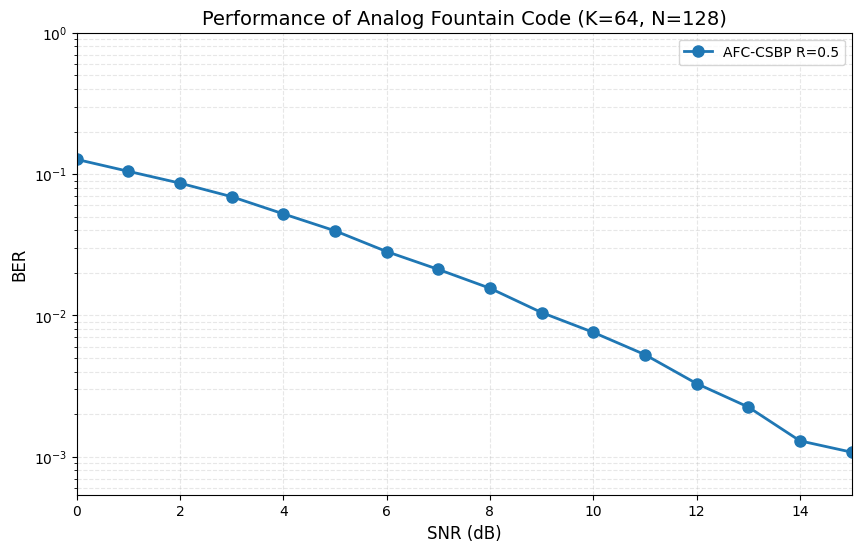

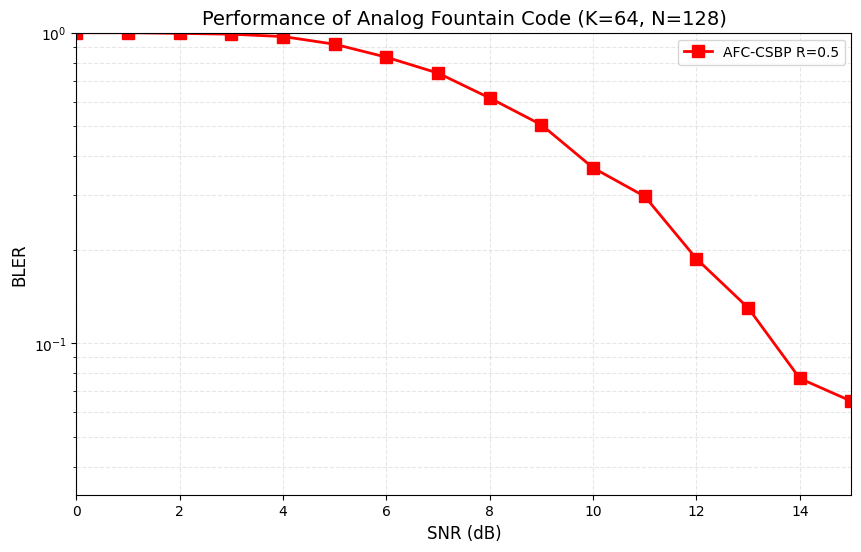

In [5]:
def plot_performance(results, k, rate, label="AFC-CSBP"):
    """
    Creates two separate plots: BER vs SNR and BLER vs SNR.
    
    Parameters:
        results (dict): Simulation results.
        k (int): Number of information bits.
        rate (float): Code rate.
        label (str): Label for the curve.
    """
    n = int(k / rate)
    
    # 1. BER vs SNR Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(results['snr'], results['ber'], 'o-', color='#1f77b4', linewidth=2, 
                markersize=8, label=f"{label} R={rate}")
    
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('BER', fontsize=12)
    plt.title(f'Performance of Analog Fountain Code (K={k}, N={n})', fontsize=14)
    plt.xlim(0, 15)
    
    # Set y-axis limits based on data
    min_error = max(1e-3, min(filter(lambda x: x > 0, results['ber'])))
    plt.ylim(min_error / 2, 1)
    
    plt.legend(fontsize=10)
    plt.savefig(f'afc_ber_performance_k{k}_n{n}_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. BLER vs SNR Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(results['snr'], results['bler'], 's-', color='red', linewidth=2, 
                markersize=8, label=f"{label} R={rate}")
    
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('BLER', fontsize=12)
    plt.title(f'Performance of Analog Fountain Code (K={k}, N={n})', fontsize=14)
    plt.xlim(0, 15)
    
    # Set y-axis limits based on data
    min_error = max(1e-3, min(filter(lambda x: x > 0, results['bler'])))
    plt.ylim(min_error / 2, 1)
    
    plt.legend(fontsize=10)
    plt.savefig(f'afc_bler_performance_k{k}_n{n}_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_performance(results, k, rate, label="AFC-CSBP")